In [1]:
from medmnist import PneumoniaMNIST
from medmnist import INFO

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA

import pennylane as qml
from pennylane import numpy as np
from pennylane import draw_mpl
from pennylane.qnn import TorchLayer

In [2]:
def load_data(batch_size=32, train_fraction=0.2, val_fraction=1.0, test_fraction=1.0):
    data_flag = "pneumoniamnist"
    info = INFO[data_flag]
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)


    if train_fraction < 1.0:
        n_train = int(len(train_dataset) * train_fraction)
        indices = np.random.choice(len(train_dataset), n_train, replace=False)
        train_dataset = Subset(train_dataset, indices)

    if val_fraction < 1.0:
        n_val = int(len(val_dataset) * val_fraction)
        indices = np.random.choice(len(val_dataset), n_val, replace=False)
        val_dataset = Subset(val_dataset, indices)

    if test_fraction < 1.0:
        n_test = int(len(test_dataset) * test_fraction)
        indices = np.random.choice(len(test_dataset), n_test, replace=False)
        test_dataset = Subset(test_dataset, indices)
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset

In [3]:
def extract_xy_from_loader(dataloader):
    x_all = []
    y_all = []

    for x_batch, y_batch in dataloader:
        x_all.append(x_batch.view(x_batch.size(0), -1))
        y_all.append(y_batch)

    x = torch.cat(x_all, dim=0)
    y = torch.cat(y_all, dim=0)

    return x, y

In [4]:
def sample_batch(dataloader, n_samples=8, device='cpu'):
    for x, y in dataloader:
        x = x.view(x.size(0), -1).to(device)
        y = y.to(device)

        if n_samples <= x.size(0):
            return x[:n_samples], y[:n_samples]
        else:
            raise ValueError(f"Batch size {x.size(0)} is smaller than requested {n_samples}")

In [5]:
def show_images_batch(x_batch, y_batch, n_cols=4):
    n_samples = x_batch.size(0)
    n_rows = (n_samples + n_cols -1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

    if x_batch.ndim == 2:
        x_batch = x_batch.view(n_samples, 1, 4, 1)

    axes = axes.flatten() if n_samples > 1 else [axes]

    for i in range(n_samples):
        image = x_batch[i].squeeze().cpu().numpy()
        label = y_batch[i].item()
        axes[i].imshow(image, cmap='gray', aspect="auto")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
class PCAEncoder:
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, dataloader):
        all_images = []
        for x, _ in dataloader:
            x = x.view(x.size(0), -1)
            all_images.append(x)
        X = torch.cat(all_images, dim=0).numpy()
        self.pca.fit(X)
        self.fitted = True

    # def transform(self, x):
    #     if not self.fitted:
    #         raise RuntimeError("PCAEncoder must be fit before calling transform.")
    #     x = x.view(x.size(0), -1).numpy()
    #     return torch.tensor(self.pca.transform(x), dtype=torch.float32)

    def transform(self, dataloader):
        if not self.fitted:
            raise RuntimeError("PCA Encoder mus be fit before calling transform.")

        all_transformed = []
        all_labels = []
        for x, y in dataloader:
            x = x.view(x.size(0), -1).numpy()
            x_transformed = self.pca.transform(x)
            all_transformed.append(torch.tensor(x_transformed, dtype=torch.float32))
            all_labels.append(y)

        x_all = torch.cat(all_transformed, dim=0)
        y_all = torch.cat(all_labels, dim=0)
        return x_all, y_all

        # return torch.cat(all_transformed, dim=0)

    # def fit_transform(self, dataloader):
    #     self.fit(dataloader)
    #     return self.transform(dataloader)

In [7]:
# train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.1)
train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=1)

In [8]:
encoder = PCAEncoder(n_components=4)
encoder.fit(train_loader)

x_train_encoded, y_train_tensor = encoder.transform(train_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_loader)

In [9]:
def visualize_umap(X, y):
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="viridis", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.grid(True)
    plt.show()

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


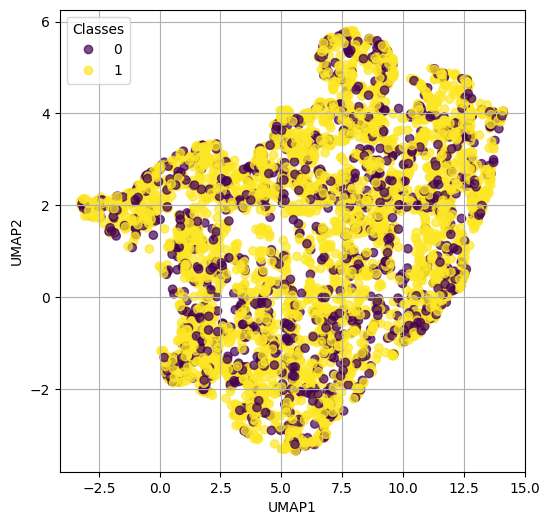

In [10]:
y_train = torch.cat([y for _, y in train_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


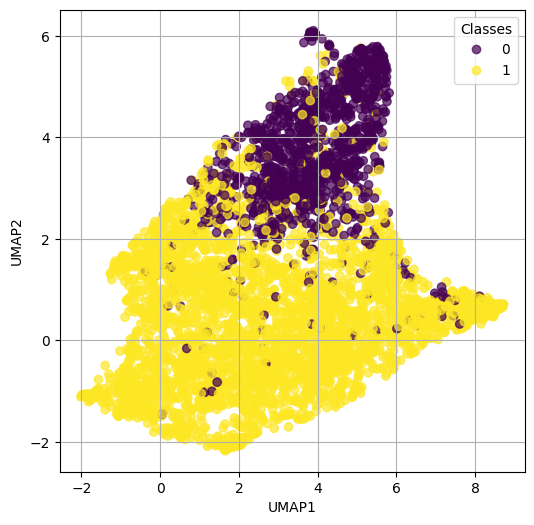

In [11]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

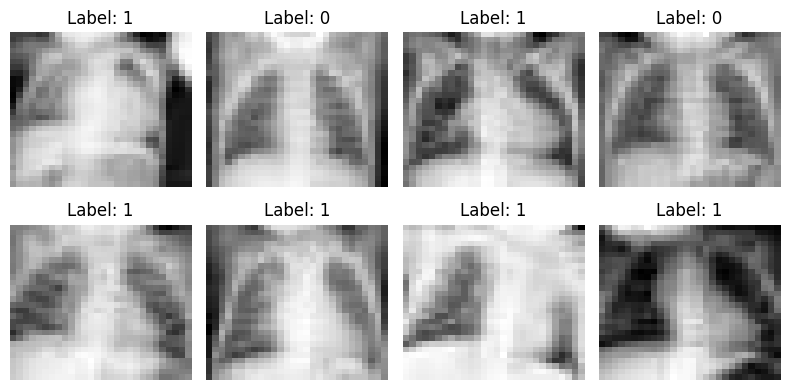

In [12]:
#original images
x_batch, y_batch = sample_batch(train_loader, n_samples=8)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_405791/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


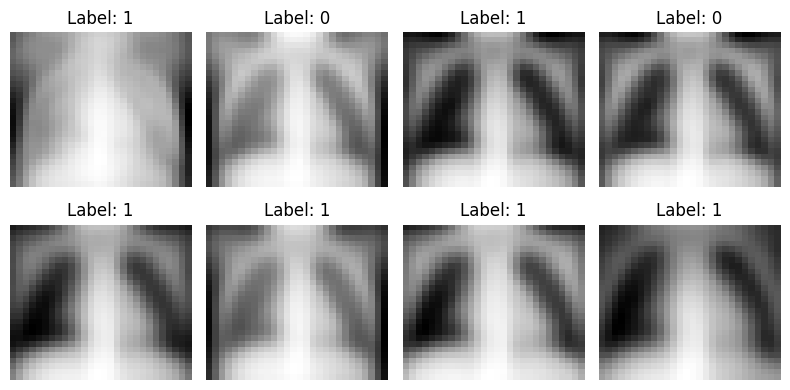

In [13]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

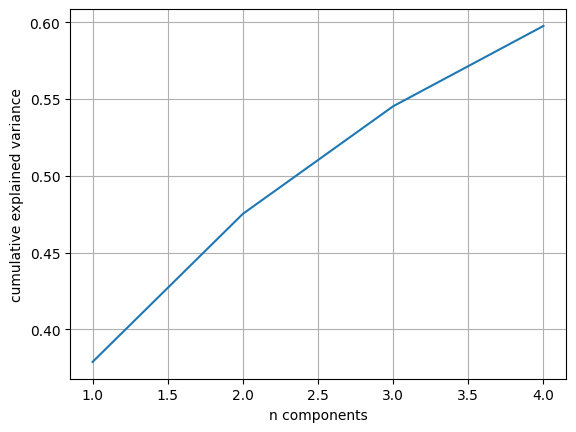

In [14]:
plt.plot(np.arange(1, len(encoder.pca.explained_variance_ratio_) + 1),
         np.cumsum(encoder.pca.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

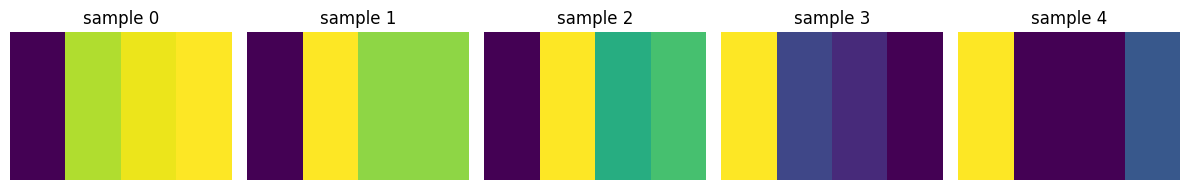

In [15]:
plt.figure(figsize=(12, 2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.heatmap(x_train_encoded[i].unsqueeze(0), cmap="viridis", cbar=False)
    plt.title(f"sample {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
n_qumodes = 4
dev = qml.device("default.gaussian", wires=n_qumodes, shots=None)
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def cv_qcnn(inputs, weights):
    for i in range(n_qumodes):
        qml.Displacement(inputs[i], 0.0, wires=i)

    for l in range(weights.shape[0]):
        for i in range(n_qumodes):
            qml.Rotation(weights[l, i, 0], wires=i)
            qml.Squeezing(weights[l, i, 1], 0.0, wires=i)
        qml.Beamsplitter(weights[l, 0, 2], weights[l, 0, 3], wires=[0, 1])


    return [qml.expval(qml.X(wires=i)) for i in range(n_qumodes)]


In [17]:

#dummy inputs: n_qumodes
dummy_inputs = torch.zeros(n_qumodes)
#dummy weights: number of layers, n_qumodes, n_input_features

dummy_weights = torch.zeros((2, n_qumodes, 6))

drawer = qml.draw(cv_qcnn)
print(drawer(dummy_inputs, dummy_weights))

0: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╭BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╭BS(0.00,0.00)─┤
1: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╰BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╰BS(0.00,0.00)─┤
2: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤
3: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤

   <X>
   <X>
   <X>
   <X>


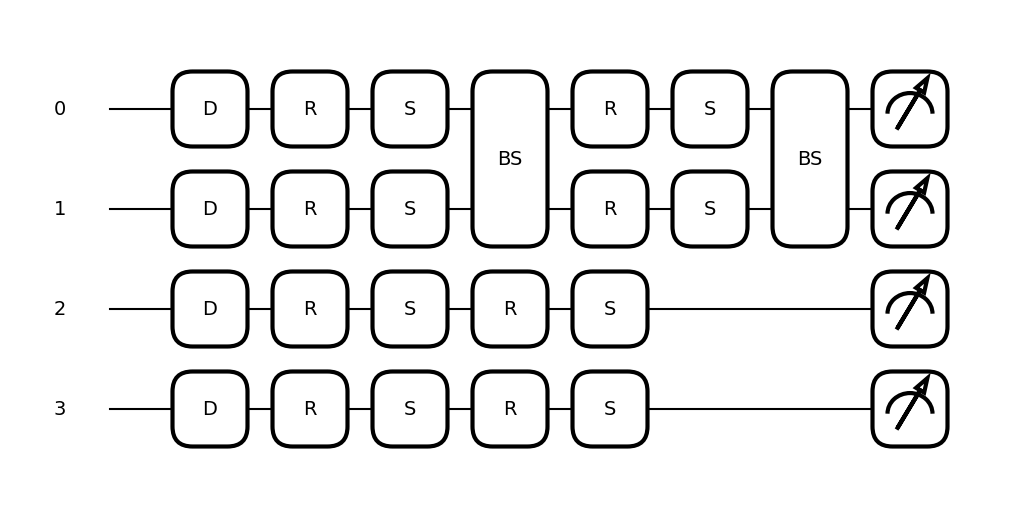

In [18]:
fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights)
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.fit_transform(x_val_encoded)
x_test_scaled = scaler.fit_transform(x_test_encoded)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [20]:
print(x_train_tensor[0])

tensor([-0.2479,  0.3920,  0.4277,  0.2608])


In [21]:
print(x_train_tensor[0].shape)

torch.Size([4])


In [22]:
weights = np.random.rand(2, n_qumodes, 4)
output = cv_qcnn(x_train_tensor[0], weights)

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


In [23]:
print(output)

tensor([-0.8162,  0.2983, -0.0272,  0.0654], dtype=torch.float64)


In [24]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
class QuantumWrapper(nn.Module):
    def __init__(self, n_qumodes=4, n_classes=2, hidden_dim=16):
        super().__init__()

        weight_shapes = {"weights": (2, n_qumodes, 4)}

        # self.quantum = TorchLayer(
            # qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn),
            # weight_shapes
        # )

        qnode = qml.QNode(cv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)
        
        self.head = nn.Sequential(
            nn.Linear(n_qumodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

In [26]:
class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.head(x)

In [27]:
# def train_v2(model, dataloader, optimizer, loss_fn, device, results_path, model_path):
def train_v2(model, dataloader, optimizer, loss_fn, device):

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    model.train()

    total_loss = 0
    total_samples = 0
    correct = 0
    all_labels = []
    all_preds = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}",
        })

        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = f1_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics

In [28]:
# def train(model, dataloader, optimizer, loss_fn, device):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     for x_batch, y_batch in progress_bar:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         # print(x_batch.shape)
#         optimizer.zero_grad()
#         logits = model(x_batch)
#         y_batch = y_batch.view(-1).long()
#         # print(logits.shape)
#         loss = criterion(logits, y_batch)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * x_batch.size(0)
#         pred = logits.argmax(dim=1)
#         correct += (pred == y_batch).sum().item()
#         total_samples += x_batch.size(0)

#         progress_bar.set_postfix({
#             "loss": f"{loss.item():.4f}",
#             "acc": f"{(correct/total_samples):.4f}"
#         })

#     avg_loss = total_loss / total_samples
#     avg_acc = correct / total_samples
#     return avg_loss, avg_acc

In [29]:
def evaluate_v2(model, dataloader, loss_fn, device):
    model.eval()

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    all_probs = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}"
        })

        all_probs.extend(probs.cpu().detach().numpy())
        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = recall_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics, all_preds, all_probs, all_labels
    

In [30]:
from sklearn.model_selection import StratifiedKFold

def run_kfold_training(model_class, dataset, optimizer, criterion, classical=False, k=5, num_epochs=10, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    labels = np.array([label for _, label in dataset])

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n Fold {fold+1}/{k}")

        all_train_metrics = {"acc": [], "loss": [], "prec": [], "rec": [], "f1": []}
        all_val_metrics = {"acc": [], "loss": [], "prec": [], "rec": [], "f1": []}
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)

        # model = model_class().to(device)

        for epoch in range(num_epochs):
            train_loss, train_acc, train_prec, train_rec, train_f1, _ = train_v2(model_class, train_loader, optimizer, criterion, device)
            val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _, _ = evaluate_v2(model_class, val_loader, criterion, device)



            all_train_metrics["acc"].append(train_acc)
            all_train_metrics["loss"].append(train_loss)
            all_train_metrics["prec"].append(train_prec)
            all_train_metrics["rec"].append(train_rec)
            all_train_metrics["f1"].append(train_f1)

            all_val_metrics["acc"].append(val_acc)
            all_val_metrics["loss"].append(val_loss)
            all_val_metrics["prec"].append(val_prec)
            all_val_metrics["rec"].append(val_rec)
            all_val_metrics["f1"].append(val_f1)

            tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
            tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

        if classical:
            with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_metrics.pkl", "wb") as f:
                pickle.dump((all_train_metrics, all_val_metrics), f)
    
            torch.save(model_class.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_best.pth")

        else:
            with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "wb") as f:
                pickle.dump((all_train_metrics, all_val_metrics), f)
    
            torch.save(model_class.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_best.pth")

    # return all_train_metrics, all_val_metrics

In [31]:
def plot_metric_with_std(metric_name, train_folds, val_folds, epochs):
    train_array = np.array(train_folds[metric_name])
    val_array = np.array(val_folds[metric_name])

    train_mean = np.mean(train_array, axis=0)
    train_std = np.std(train_array, axis=0)
    val_mean = np.mean(val_array, axis=0)
    val_std = np.std(val_array, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mean, label="Train", color="blue", marker="o")
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

    plt.plot(epochs, val_mean, label="Validation", color="green", marker="^")
    plt.fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

    plt.xlabel("Epochs")
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "metric": metric_name,
        "train_name": float(train_mean[-1]),
        "train_std": float(train_std[-1]),
        "val_mean": float(val_mean[-1]),
        "val_std": float(val_std[-1]),
    }

In [32]:
# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total_correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     with torch.no_grad():
#         for x_batch, y_batch in progress_bar:
#             x_batch = x_batch.to(device)
#             y_batch = y_batch.to(device)

#             outputs = model(x_batch)
#             y_batch = y_batch.view(-1).long()
#             loss = criterion(outputs, y_batch)

#             total_loss += loss.item() * x_batch.size(0)
#             pred = outputs.argmax(dim=1)
#             correct += (pred == y_batch).sum().item()
#             total_samples += x_batch.size(0)

#             progress_bar.set_postfix({
#                 "loss": f"{loss.item():.4f}",
#                 "acc": f"{(correct/total_samples):.4f}"
#             })

#         avg_loss = total_loss / total_samples
#         avg_acc = correct / total_samples
#         return avg_loss, avg_acc

In [33]:
# epochs = 10
epochs = 30
device = "cpu"
cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
import pickle
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumWrapper                           --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 146
Trainable params: 146
Non-trainable params: 0

In [34]:
run_kfold_training(cv_model, train_dataset, optimizer, criterion, classical=False, k=3, num_epochs=epochs, seed=42)


 Fold 1/3


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.35it/s, loss=0.7381, acc=0.8618]


Train loss: 2.1204 | Train acc: 0.8343 | Train rec: 0.8343 | Train prec: 0.8338 | Train f1: 0.8340
Val loss: 0.7381 | Val acc: 0.8618 | Val rec: 0.8618 | Val prec: 0.8706 | Val f1: 0.8618


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.3043, acc=0.8586]


Train loss: 0.4060 | Train acc: 0.8588 | Train rec: 0.8588 | Train prec: 0.8699 | Train f1: 0.8624
Val loss: 0.3043 | Val acc: 0.8586 | Val rec: 0.8586 | Val prec: 0.8753 | Val f1: 0.8586


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.40it/s, loss=0.3022, acc=0.8688]


Train loss: 0.2901 | Train acc: 0.8713 | Train rec: 0.8713 | Train prec: 0.8866 | Train f1: 0.8753
Val loss: 0.3022 | Val acc: 0.8688 | Val rec: 0.8688 | Val prec: 0.8801 | Val f1: 0.8688


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.92it/s, loss=0.2902, acc=0.8669]


Train loss: 0.3170 | Train acc: 0.8662 | Train rec: 0.8662 | Train prec: 0.8738 | Train f1: 0.8688
Val loss: 0.2902 | Val acc: 0.8669 | Val rec: 0.8669 | Val prec: 0.8796 | Val f1: 0.8669


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.31it/s, loss=0.5101, acc=0.8732]


Train loss: 0.3078 | Train acc: 0.8697 | Train rec: 0.8697 | Train prec: 0.8757 | Train f1: 0.8718
Val loss: 0.5101 | Val acc: 0.8732 | Val rec: 0.8732 | Val prec: 0.8831 | Val f1: 0.8732


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.48it/s, loss=0.2868, acc=0.8732]


Train loss: 0.3007 | Train acc: 0.8770 | Train rec: 0.8770 | Train prec: 0.8827 | Train f1: 0.8790
Val loss: 0.2868 | Val acc: 0.8732 | Val rec: 0.8732 | Val prec: 0.8820 | Val f1: 0.8732


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.44it/s, loss=0.2825, acc=0.8834]


Train loss: 0.2779 | Train acc: 0.8821 | Train rec: 0.8821 | Train prec: 0.8873 | Train f1: 0.8840
Val loss: 0.2825 | Val acc: 0.8834 | Val rec: 0.8834 | Val prec: 0.8889 | Val f1: 0.8834


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.99it/s, loss=0.2729, acc=0.8822]


Train loss: 0.2683 | Train acc: 0.8805 | Train rec: 0.8805 | Train prec: 0.8843 | Train f1: 0.8820
Val loss: 0.2729 | Val acc: 0.8822 | Val rec: 0.8822 | Val prec: 0.8871 | Val f1: 0.8822


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.2809, acc=0.8803]


Train loss: 0.2771 | Train acc: 0.8795 | Train rec: 0.8795 | Train prec: 0.8815 | Train f1: 0.8804
Val loss: 0.2809 | Val acc: 0.8803 | Val rec: 0.8803 | Val prec: 0.8815 | Val f1: 0.8803


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.40it/s, loss=0.2931, acc=0.8790]


Train loss: 0.2717 | Train acc: 0.8859 | Train rec: 0.8859 | Train prec: 0.8864 | Train f1: 0.8861
Val loss: 0.2931 | Val acc: 0.8790 | Val rec: 0.8790 | Val prec: 0.8836 | Val f1: 0.8790


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.46it/s, loss=0.2702, acc=0.8879]


Train loss: 0.2694 | Train acc: 0.8846 | Train rec: 0.8846 | Train prec: 0.8836 | Train f1: 0.8841
Val loss: 0.2702 | Val acc: 0.8879 | Val rec: 0.8879 | Val prec: 0.8879 | Val f1: 0.8879


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.47it/s, loss=0.2819, acc=0.8854]


Train loss: 0.2705 | Train acc: 0.8837 | Train rec: 0.8837 | Train prec: 0.8819 | Train f1: 0.8826
Val loss: 0.2819 | Val acc: 0.8854 | Val rec: 0.8854 | Val prec: 0.8875 | Val f1: 0.8854


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.96it/s, loss=0.2733, acc=0.8943]


Train loss: 0.2656 | Train acc: 0.8872 | Train rec: 0.8872 | Train prec: 0.8855 | Train f1: 0.8861
Val loss: 0.2733 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8922 | Val f1: 0.8943


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.2533, acc=0.8955]


Train loss: 0.2763 | Train acc: 0.8853 | Train rec: 0.8853 | Train prec: 0.8827 | Train f1: 0.8833
Val loss: 0.2533 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8938 | Val f1: 0.8955


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.3414, acc=0.8866]


Train loss: 0.2650 | Train acc: 0.8862 | Train rec: 0.8862 | Train prec: 0.8839 | Train f1: 0.8845
Val loss: 0.3414 | Val acc: 0.8866 | Val rec: 0.8866 | Val prec: 0.8897 | Val f1: 0.8866


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.28it/s, loss=0.2609, acc=0.8924]


Train loss: 0.2654 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8867 | Train f1: 0.8873
Val loss: 0.2609 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8916 | Val f1: 0.8924


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.2750, acc=0.8898]


Train loss: 0.2711 | Train acc: 0.8856 | Train rec: 0.8856 | Train prec: 0.8841 | Train f1: 0.8847
Val loss: 0.2750 | Val acc: 0.8898 | Val rec: 0.8898 | Val prec: 0.8915 | Val f1: 0.8898


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.2746, acc=0.8866]


Train loss: 0.2558 | Train acc: 0.8888 | Train rec: 0.8888 | Train prec: 0.8864 | Train f1: 0.8869
Val loss: 0.2746 | Val acc: 0.8866 | Val rec: 0.8866 | Val prec: 0.8880 | Val f1: 0.8866


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.37it/s, loss=0.2514, acc=0.8924]


Train loss: 0.3130 | Train acc: 0.8719 | Train rec: 0.8719 | Train prec: 0.8706 | Train f1: 0.8711
Val loss: 0.2514 | Val acc: 0.8924 | Val rec: 0.8924 | Val prec: 0.8930 | Val f1: 0.8924


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.91it/s, loss=0.2524, acc=0.8943]


Train loss: 0.2574 | Train acc: 0.8866 | Train rec: 0.8866 | Train prec: 0.8850 | Train f1: 0.8856
Val loss: 0.2524 | Val acc: 0.8943 | Val rec: 0.8943 | Val prec: 0.8922 | Val f1: 0.8943


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.99it/s, loss=0.2504, acc=0.8975]


Train loss: 0.2447 | Train acc: 0.8897 | Train rec: 0.8897 | Train prec: 0.8879 | Train f1: 0.8885
Val loss: 0.2504 | Val acc: 0.8975 | Val rec: 0.8975 | Val prec: 0.8959 | Val f1: 0.8975


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.33it/s, loss=0.2493, acc=0.8968]


Train loss: 0.2408 | Train acc: 0.8875 | Train rec: 0.8875 | Train prec: 0.8855 | Train f1: 0.8861
Val loss: 0.2493 | Val acc: 0.8968 | Val rec: 0.8968 | Val prec: 0.8963 | Val f1: 0.8968


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.24it/s, loss=0.2443, acc=0.8949]


Train loss: 0.2476 | Train acc: 0.8830 | Train rec: 0.8830 | Train prec: 0.8817 | Train f1: 0.8822
Val loss: 0.2443 | Val acc: 0.8949 | Val rec: 0.8949 | Val prec: 0.8950 | Val f1: 0.8949


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.95it/s, loss=0.2681, acc=0.8898]


Train loss: 0.2432 | Train acc: 0.8901 | Train rec: 0.8901 | Train prec: 0.8882 | Train f1: 0.8888
Val loss: 0.2681 | Val acc: 0.8898 | Val rec: 0.8898 | Val prec: 0.8915 | Val f1: 0.8898


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.27it/s, loss=0.2537, acc=0.8936]


Train loss: 0.2452 | Train acc: 0.8907 | Train rec: 0.8907 | Train prec: 0.8890 | Train f1: 0.8896
Val loss: 0.2537 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8951 | Val f1: 0.8936


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.39it/s, loss=0.2563, acc=0.8949]


Train loss: 0.2468 | Train acc: 0.8866 | Train rec: 0.8866 | Train prec: 0.8850 | Train f1: 0.8856
Val loss: 0.2563 | Val acc: 0.8949 | Val rec: 0.8949 | Val prec: 0.8936 | Val f1: 0.8949


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.36it/s, loss=0.2651, acc=0.8885]


Train loss: 0.2496 | Train acc: 0.8878 | Train rec: 0.8878 | Train prec: 0.8863 | Train f1: 0.8869
Val loss: 0.2651 | Val acc: 0.8885 | Val rec: 0.8885 | Val prec: 0.8862 | Val f1: 0.8885


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.32it/s, loss=0.2484, acc=0.8975]


Train loss: 0.2423 | Train acc: 0.8878 | Train rec: 0.8878 | Train prec: 0.8861 | Train f1: 0.8867
Val loss: 0.2484 | Val acc: 0.8975 | Val rec: 0.8975 | Val prec: 0.8958 | Val f1: 0.8975


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.88it/s, loss=0.2466, acc=0.9000]


Train loss: 0.2470 | Train acc: 0.8846 | Train rec: 0.8846 | Train prec: 0.8829 | Train f1: 0.8835
Val loss: 0.2466 | Val acc: 0.9000 | Val rec: 0.9000 | Val prec: 0.8980 | Val f1: 0.9000


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.37it/s, loss=0.2416, acc=0.8975]


Train loss: 0.2489 | Train acc: 0.8872 | Train rec: 0.8872 | Train prec: 0.8851 | Train f1: 0.8858
Val loss: 0.2416 | Val acc: 0.8975 | Val rec: 0.8975 | Val prec: 0.8969 | Val f1: 0.8975

 Fold 2/3


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.40it/s, loss=0.2456, acc=0.8840]


Train loss: 0.2421 | Train acc: 0.8958 | Train rec: 0.8958 | Train prec: 0.8950 | Train f1: 0.8954
Val loss: 0.2456 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8820 | Val f1: 0.8840


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.34it/s, loss=0.2450, acc=0.8853]


Train loss: 0.2405 | Train acc: 0.8955 | Train rec: 0.8955 | Train prec: 0.8941 | Train f1: 0.8946
Val loss: 0.2450 | Val acc: 0.8853 | Val rec: 0.8853 | Val prec: 0.8831 | Val f1: 0.8853


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.31it/s, loss=0.2509, acc=0.8802]


Train loss: 0.2465 | Train acc: 0.8955 | Train rec: 0.8955 | Train prec: 0.8940 | Train f1: 0.8945
Val loss: 0.2509 | Val acc: 0.8802 | Val rec: 0.8802 | Val prec: 0.8791 | Val f1: 0.8802


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.95it/s, loss=0.2431, acc=0.8866]


Train loss: 0.2419 | Train acc: 0.8961 | Train rec: 0.8961 | Train prec: 0.8948 | Train f1: 0.8953
Val loss: 0.2431 | Val acc: 0.8866 | Val rec: 0.8866 | Val prec: 0.8845 | Val f1: 0.8866


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.35it/s, loss=0.2442, acc=0.8853]


Train loss: 0.2406 | Train acc: 0.8971 | Train rec: 0.8971 | Train prec: 0.8957 | Train f1: 0.8962
Val loss: 0.2442 | Val acc: 0.8853 | Val rec: 0.8853 | Val prec: 0.8831 | Val f1: 0.8853


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.40it/s, loss=0.2470, acc=0.8859]


Train loss: 0.2415 | Train acc: 0.8955 | Train rec: 0.8955 | Train prec: 0.8940 | Train f1: 0.8945
Val loss: 0.2470 | Val acc: 0.8859 | Val rec: 0.8859 | Val prec: 0.8844 | Val f1: 0.8859


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.43it/s, loss=0.2467, acc=0.8859]


Train loss: 0.2411 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8975 | Train f1: 0.8980
Val loss: 0.2467 | Val acc: 0.8859 | Val rec: 0.8859 | Val prec: 0.8843 | Val f1: 0.8859


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.94it/s, loss=0.2551, acc=0.8840]


Train loss: 0.2388 | Train acc: 0.8955 | Train rec: 0.8955 | Train prec: 0.8939 | Train f1: 0.8944
Val loss: 0.2551 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8835 | Val f1: 0.8840


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.35it/s, loss=0.2446, acc=0.8808]


Train loss: 0.2404 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8973 | Train f1: 0.8978
Val loss: 0.2446 | Val acc: 0.8808 | Val rec: 0.8808 | Val prec: 0.8781 | Val f1: 0.8808


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.34it/s, loss=0.2459, acc=0.8795]


Train loss: 0.2402 | Train acc: 0.8952 | Train rec: 0.8952 | Train prec: 0.8939 | Train f1: 0.8944
Val loss: 0.2459 | Val acc: 0.8795 | Val rec: 0.8795 | Val prec: 0.8766 | Val f1: 0.8795


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.26it/s, loss=0.2448, acc=0.8846]


Train loss: 0.2413 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8975 | Train f1: 0.8980
Val loss: 0.2448 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.8825 | Val f1: 0.8846


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.43it/s, loss=0.2450, acc=0.8840]


Train loss: 0.2393 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8925 | Train f1: 0.8929
Val loss: 0.2450 | Val acc: 0.8840 | Val rec: 0.8840 | Val prec: 0.8812 | Val f1: 0.8840


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.2583, acc=0.8859]


Train loss: 0.2381 | Train acc: 0.8974 | Train rec: 0.8974 | Train prec: 0.8961 | Train f1: 0.8966
Val loss: 0.2583 | Val acc: 0.8859 | Val rec: 0.8859 | Val prec: 0.8837 | Val f1: 0.8859


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.27it/s, loss=0.2449, acc=0.8891]


Train loss: 0.2396 | Train acc: 0.8971 | Train rec: 0.8971 | Train prec: 0.8953 | Train f1: 0.8958
Val loss: 0.2449 | Val acc: 0.8891 | Val rec: 0.8891 | Val prec: 0.8867 | Val f1: 0.8891


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.2490, acc=0.8904]


Train loss: 0.2333 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8977 | Train f1: 0.8981
Val loss: 0.2490 | Val acc: 0.8904 | Val rec: 0.8904 | Val prec: 0.8878 | Val f1: 0.8904


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.35it/s, loss=0.2474, acc=0.8929]


Train loss: 0.2400 | Train acc: 0.8993 | Train rec: 0.8993 | Train prec: 0.8974 | Train f1: 0.8977
Val loss: 0.2474 | Val acc: 0.8929 | Val rec: 0.8929 | Val prec: 0.8912 | Val f1: 0.8929


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.08it/s, loss=0.2503, acc=0.8910]


Train loss: 0.2340 | Train acc: 0.9032 | Train rec: 0.9032 | Train prec: 0.9017 | Train f1: 0.9022
Val loss: 0.2503 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8904 | Val f1: 0.8910


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.97it/s, loss=0.2460, acc=0.8910]


Train loss: 0.2322 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8988 | Train f1: 0.8993
Val loss: 0.2460 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8890 | Val f1: 0.8910


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.93it/s, loss=0.2434, acc=0.8866]


Train loss: 0.2337 | Train acc: 0.9019 | Train rec: 0.9019 | Train prec: 0.9009 | Train f1: 0.9013
Val loss: 0.2434 | Val acc: 0.8866 | Val rec: 0.8866 | Val prec: 0.8839 | Val f1: 0.8866


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.45it/s, loss=0.2386, acc=0.8955]


Train loss: 0.2307 | Train acc: 0.8971 | Train rec: 0.8971 | Train prec: 0.8953 | Train f1: 0.8958
Val loss: 0.2386 | Val acc: 0.8955 | Val rec: 0.8955 | Val prec: 0.8932 | Val f1: 0.8955


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.45it/s, loss=0.2332, acc=0.8936]


Train loss: 0.2288 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8970 | Train f1: 0.8975
Val loss: 0.2332 | Val acc: 0.8936 | Val rec: 0.8936 | Val prec: 0.8914 | Val f1: 0.8936


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.40it/s, loss=0.2334, acc=0.8974]


Train loss: 0.2263 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8972 | Train f1: 0.8977
Val loss: 0.2334 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8956 | Val f1: 0.8974


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.32it/s, loss=0.2313, acc=0.8987]


Train loss: 0.2232 | Train acc: 0.9022 | Train rec: 0.9022 | Train prec: 0.9006 | Train f1: 0.9011
Val loss: 0.2313 | Val acc: 0.8987 | Val rec: 0.8987 | Val prec: 0.8968 | Val f1: 0.8987


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.93it/s, loss=0.2367, acc=0.9006]


Train loss: 0.2230 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.8995 | Train f1: 0.9000
Val loss: 0.2367 | Val acc: 0.9006 | Val rec: 0.9006 | Val prec: 0.8991 | Val f1: 0.9006


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.44it/s, loss=0.2370, acc=0.9044]


Train loss: 0.2248 | Train acc: 0.9025 | Train rec: 0.9025 | Train prec: 0.9008 | Train f1: 0.9013
Val loss: 0.2370 | Val acc: 0.9044 | Val rec: 0.9044 | Val prec: 0.9028 | Val f1: 0.9044


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.31it/s, loss=0.2332, acc=0.9006]


Train loss: 0.2231 | Train acc: 0.9019 | Train rec: 0.9019 | Train prec: 0.9002 | Train f1: 0.9007
Val loss: 0.2332 | Val acc: 0.9006 | Val rec: 0.9006 | Val prec: 0.8988 | Val f1: 0.9006


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.2296, acc=0.9018]


Train loss: 0.2239 | Train acc: 0.9016 | Train rec: 0.9016 | Train prec: 0.9002 | Train f1: 0.9007
Val loss: 0.2296 | Val acc: 0.9018 | Val rec: 0.9018 | Val prec: 0.8998 | Val f1: 0.9018


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.2291, acc=0.8987]


Train loss: 0.2217 | Train acc: 0.9012 | Train rec: 0.9012 | Train prec: 0.8994 | Train f1: 0.8998
Val loss: 0.2291 | Val acc: 0.8987 | Val rec: 0.8987 | Val prec: 0.8965 | Val f1: 0.8987


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.94it/s, loss=0.2301, acc=0.9025]


Train loss: 0.2205 | Train acc: 0.9038 | Train rec: 0.9038 | Train prec: 0.9023 | Train f1: 0.9027
Val loss: 0.2301 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9006 | Val f1: 0.9025


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.88it/s, loss=0.2304, acc=0.9050]


Train loss: 0.2202 | Train acc: 0.9038 | Train rec: 0.9038 | Train prec: 0.9023 | Train f1: 0.9028
Val loss: 0.2304 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9035 | Val f1: 0.9050

 Fold 3/3


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.01it/s, loss=0.2113, acc=0.9057]


Train loss: 0.2289 | Train acc: 0.9057 | Train rec: 0.9057 | Train prec: 0.9040 | Train f1: 0.9043
Val loss: 0.2113 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9047 | Val f1: 0.9057


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.08it/s, loss=0.2157, acc=0.9025]


Train loss: 0.2290 | Train acc: 0.9019 | Train rec: 0.9019 | Train prec: 0.9003 | Train f1: 0.9007
Val loss: 0.2157 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9010 | Val f1: 0.9025


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.35it/s, loss=0.2085, acc=0.9089]


Train loss: 0.2280 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9039 | Train f1: 0.9043
Val loss: 0.2085 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9075 | Val f1: 0.9089


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.2107, acc=0.9063]


Train loss: 0.2263 | Train acc: 0.9051 | Train rec: 0.9051 | Train prec: 0.9036 | Train f1: 0.9040
Val loss: 0.2107 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9052 | Val f1: 0.9063


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.36it/s, loss=0.2131, acc=0.9057]


Train loss: 0.2260 | Train acc: 0.9038 | Train rec: 0.9038 | Train prec: 0.9022 | Train f1: 0.9026
Val loss: 0.2131 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9048 | Val f1: 0.9057


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.38it/s, loss=0.2082, acc=0.9089]


Train loss: 0.2259 | Train acc: 0.9063 | Train rec: 0.9063 | Train prec: 0.9050 | Train f1: 0.9054
Val loss: 0.2082 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9075 | Val f1: 0.9089


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.33it/s, loss=0.2122, acc=0.9057]


Train loss: 0.2256 | Train acc: 0.9057 | Train rec: 0.9057 | Train prec: 0.9043 | Train f1: 0.9047
Val loss: 0.2122 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9045 | Val f1: 0.9057


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.35it/s, loss=0.2112, acc=0.9044]


Train loss: 0.2250 | Train acc: 0.9047 | Train rec: 0.9047 | Train prec: 0.9035 | Train f1: 0.9040
Val loss: 0.2112 | Val acc: 0.9044 | Val rec: 0.9044 | Val prec: 0.9034 | Val f1: 0.9044


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.48it/s, loss=0.2163, acc=0.8999]


Train loss: 0.2252 | Train acc: 0.9060 | Train rec: 0.9060 | Train prec: 0.9047 | Train f1: 0.9051
Val loss: 0.2163 | Val acc: 0.8999 | Val rec: 0.8999 | Val prec: 0.9009 | Val f1: 0.8999


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.2111, acc=0.9031]


Train loss: 0.2258 | Train acc: 0.9047 | Train rec: 0.9047 | Train prec: 0.9037 | Train f1: 0.9041
Val loss: 0.2111 | Val acc: 0.9031 | Val rec: 0.9031 | Val prec: 0.9028 | Val f1: 0.9031


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.2106, acc=0.9012]


Train loss: 0.2247 | Train acc: 0.9083 | Train rec: 0.9083 | Train prec: 0.9073 | Train f1: 0.9077
Val loss: 0.2106 | Val acc: 0.9012 | Val rec: 0.9012 | Val prec: 0.9016 | Val f1: 0.9012


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.33it/s, loss=0.2095, acc=0.9057]


Train loss: 0.2252 | Train acc: 0.9038 | Train rec: 0.9038 | Train prec: 0.9027 | Train f1: 0.9031
Val loss: 0.2095 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9065 | Val f1: 0.9057


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.28it/s, loss=0.2132, acc=0.9018]


Train loss: 0.2232 | Train acc: 0.9051 | Train rec: 0.9051 | Train prec: 0.9041 | Train f1: 0.9045
Val loss: 0.2132 | Val acc: 0.9018 | Val rec: 0.9018 | Val prec: 0.9010 | Val f1: 0.9018


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.04it/s, loss=0.2089, acc=0.9076]


Train loss: 0.2239 | Train acc: 0.9067 | Train rec: 0.9067 | Train prec: 0.9054 | Train f1: 0.9059
Val loss: 0.2089 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9066 | Val f1: 0.9076


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.43it/s, loss=0.2119, acc=0.9063]


Train loss: 0.2233 | Train acc: 0.9038 | Train rec: 0.9038 | Train prec: 0.9029 | Train f1: 0.9033
Val loss: 0.2119 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9052 | Val f1: 0.9063


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.34it/s, loss=0.2082, acc=0.9038]


Train loss: 0.2238 | Train acc: 0.9067 | Train rec: 0.9067 | Train prec: 0.9057 | Train f1: 0.9061
Val loss: 0.2082 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9042 | Val f1: 0.9038


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.39it/s, loss=0.2095, acc=0.9044]


Train loss: 0.2247 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9063 | Train f1: 0.9067
Val loss: 0.2095 | Val acc: 0.9044 | Val rec: 0.9044 | Val prec: 0.9051 | Val f1: 0.9044


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.46it/s, loss=0.2094, acc=0.9044]


Train loss: 0.2222 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9081 | Train f1: 0.9084
Val loss: 0.2094 | Val acc: 0.9044 | Val rec: 0.9044 | Val prec: 0.9067 | Val f1: 0.9044


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.24it/s, loss=0.2087, acc=0.9057]


Train loss: 0.2232 | Train acc: 0.9051 | Train rec: 0.9051 | Train prec: 0.9043 | Train f1: 0.9046
Val loss: 0.2087 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9067 | Val f1: 0.9057


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.87it/s, loss=0.2201, acc=0.9025]


Train loss: 0.2224 | Train acc: 0.9044 | Train rec: 0.9044 | Train prec: 0.9034 | Train f1: 0.9038
Val loss: 0.2201 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9008 | Val f1: 0.9025


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.37it/s, loss=0.2131, acc=0.9044]


Train loss: 0.2233 | Train acc: 0.9044 | Train rec: 0.9044 | Train prec: 0.9034 | Train f1: 0.9038
Val loss: 0.2131 | Val acc: 0.9044 | Val rec: 0.9044 | Val prec: 0.9041 | Val f1: 0.9044


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.06it/s, loss=0.2112, acc=0.9031]


Train loss: 0.2211 | Train acc: 0.9060 | Train rec: 0.9060 | Train prec: 0.9053 | Train f1: 0.9056
Val loss: 0.2112 | Val acc: 0.9031 | Val rec: 0.9031 | Val prec: 0.9038 | Val f1: 0.9031


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.96it/s, loss=0.2081, acc=0.9069]


Train loss: 0.2239 | Train acc: 0.9035 | Train rec: 0.9035 | Train prec: 0.9023 | Train f1: 0.9027
Val loss: 0.2081 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9080 | Val f1: 0.9069


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.99it/s, loss=0.2150, acc=0.9031]


Train loss: 0.2234 | Train acc: 0.9095 | Train rec: 0.9095 | Train prec: 0.9090 | Train f1: 0.9092
Val loss: 0.2150 | Val acc: 0.9031 | Val rec: 0.9031 | Val prec: 0.9027 | Val f1: 0.9031


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.23it/s, loss=0.2081, acc=0.9076]


Train loss: 0.2268 | Train acc: 0.9076 | Train rec: 0.9076 | Train prec: 0.9073 | Train f1: 0.9075
Val loss: 0.2081 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9080 | Val f1: 0.9076


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.32it/s, loss=0.2069, acc=0.9101]


Train loss: 0.2346 | Train acc: 0.9044 | Train rec: 0.9044 | Train prec: 0.9046 | Train f1: 0.9045
Val loss: 0.2069 | Val acc: 0.9101 | Val rec: 0.9101 | Val prec: 0.9091 | Val f1: 0.9101


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.2066, acc=0.9063]


Train loss: 0.2222 | Train acc: 0.9076 | Train rec: 0.9076 | Train prec: 0.9065 | Train f1: 0.9069
Val loss: 0.2066 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9062 | Val f1: 0.9063


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.39it/s, loss=0.2147, acc=0.9082]


Train loss: 0.2221 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9080 | Train f1: 0.9084
Val loss: 0.2147 | Val acc: 0.9082 | Val rec: 0.9082 | Val prec: 0.9066 | Val f1: 0.9082


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.43it/s, loss=0.2118, acc=0.9057]


Train loss: 0.2239 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9079 | Train f1: 0.9082
Val loss: 0.2118 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9054 | Val f1: 0.9057


Training: 100%|████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.27it/s, loss=0.2113, acc=0.9069]

Train loss: 0.2221 | Train acc: 0.9067 | Train rec: 0.9067 | Train prec: 0.9056 | Train f1: 0.9060
Val loss: 0.2113 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9064 | Val f1: 0.9069


In [35]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

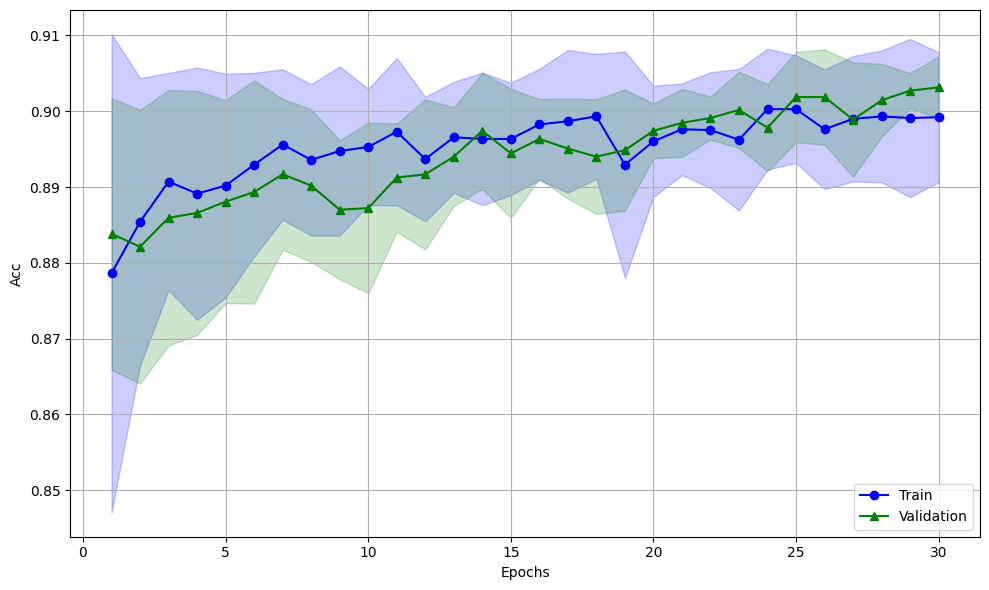

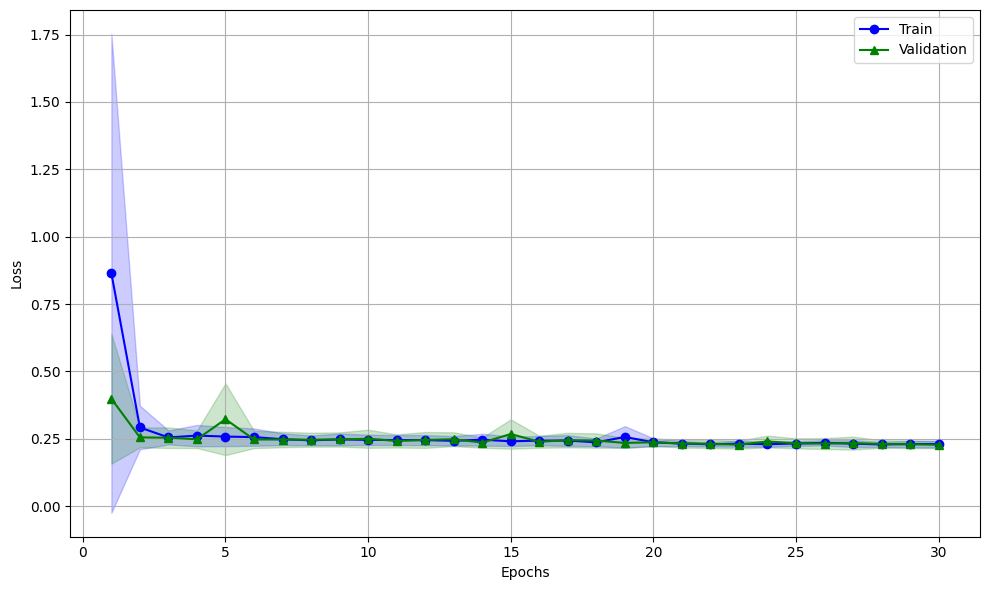

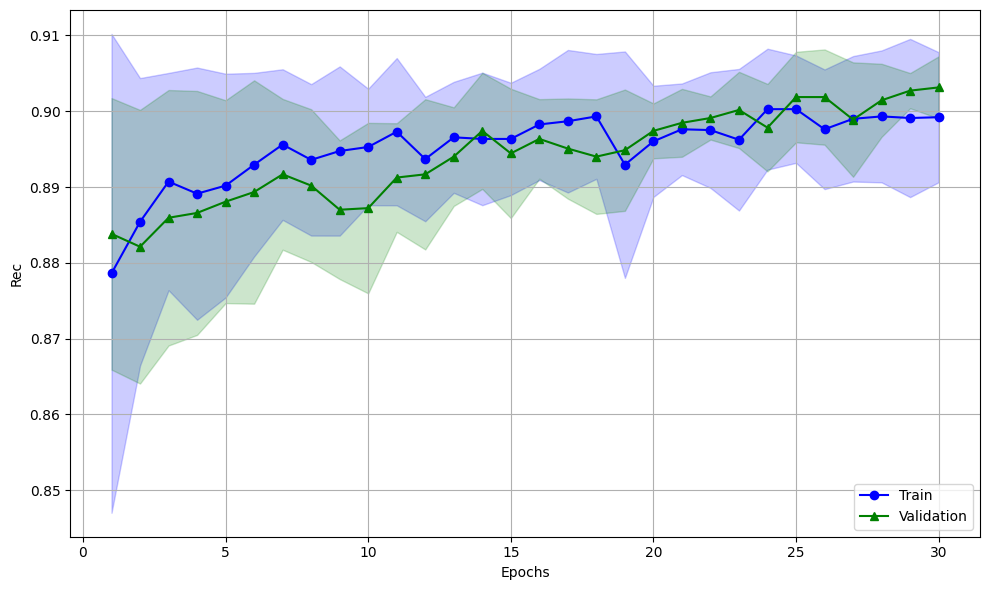

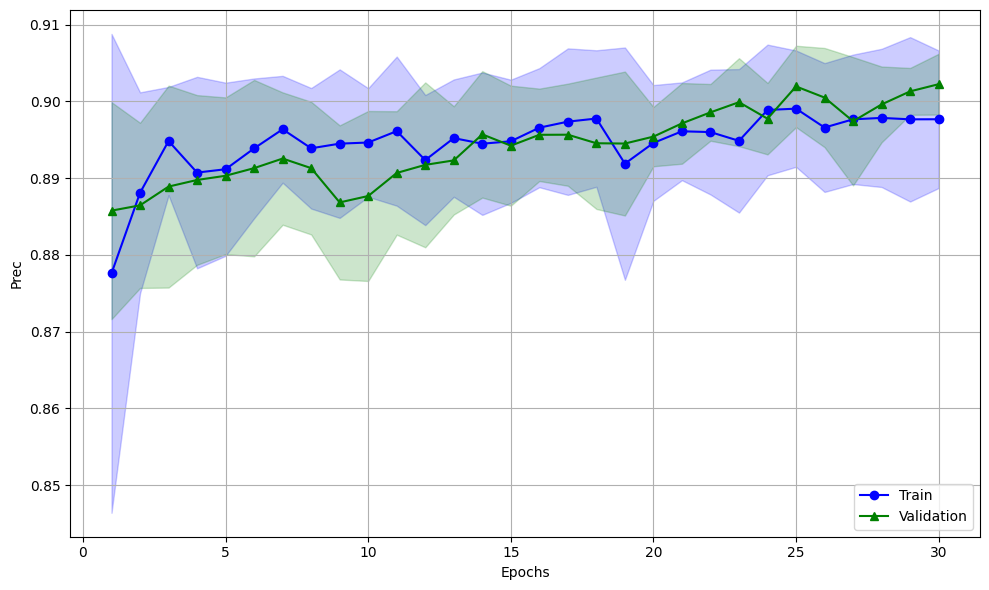

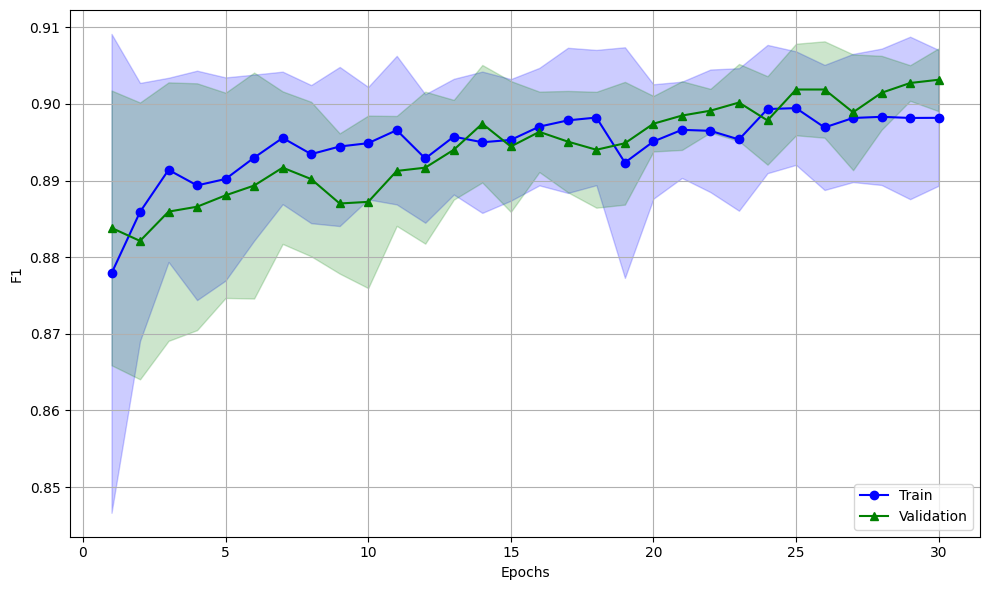

In [36]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}
import json

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range)
    metrics_summary[metric] = summary

with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [37]:
# train_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# val_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# best_val_f1 = 0

# for epoch in range(epochs):
#     print(f"epoch {epoch+1}/{epochs}")
#     train_loss, train_acc, train_prec, train_rec, train_f1, train_report = train_v2(cv_model, train_loader, optimizer, criterion, device)
#     val_loss, val_acc, val_prec, val_rec, val_f1, val_report, val_preds, val_probs, val_labels = evaluate_v2(cv_model, val_loader, criterion, device)

#     train_metrics["acc"].append(train_acc)
#     train_metrics["loss"].append(train_loss)
#     train_metrics["rec"].append(train_rec)
#     train_metrics["prec"].append(train_prec)
#     train_metrics["f1"].append(train_f1)
    
#     val_metrics["acc"].append(val_acc)
#     val_metrics["loss"].append(val_loss)
#     val_metrics["rec"].append(val_rec)
#     val_metrics["prec"].append(val_prec)
#     val_metrics["f1"].append(val_f1)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(cv_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth")
    
#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

#     tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

# import json
# with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_train_metrics.json", "w") as f:
#     json.dump(train_metrics, f, indent=4)

# with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_val_metrics.json", "w") as f:
#     json.dump(val_metrics, f, indent=4)

In [38]:
# epochs = range(1, len(train_metrics["acc"]) + 1)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_metrics["loss"], label="Train Loss", marker="o")
# plt.plot(epochs, val_metrics["loss"], label="Validation Loss", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# # plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_metrics["acc"], label="Train Accuracies", marker="o")
# plt.plot(epochs, val_metrics["acc"], label="Validation Accuracies", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)    

# plt.tight_layout()
# plt.show()

In [39]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 3 with val_f1 = 0.9069


In [40]:
device = "cpu"
test_cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
# test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth"))
test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_2_best.pth"))
test_cv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_cv_model, test_loader, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training: 100%|████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.17it/s, loss=0.6824, acc=0.7516]

Test loss: 0.6824 | Test acc: 0.7516 | Test rec: 0.7516 | Test prec: 0.7473 | Test f1: 0.7516


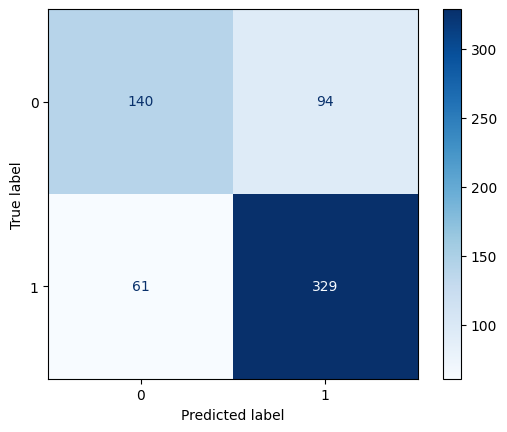

In [41]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

AUROC: 0.7969099276791585


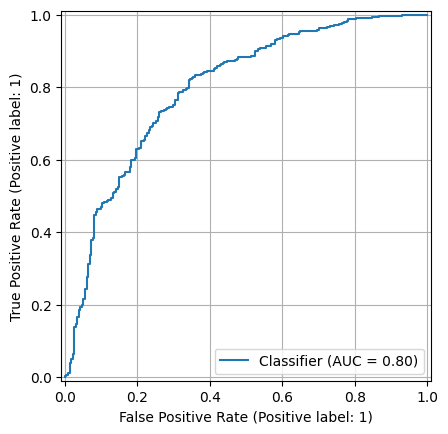

In [42]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
print("AUROC:", auroc)

RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
plt.grid()
plt.show()

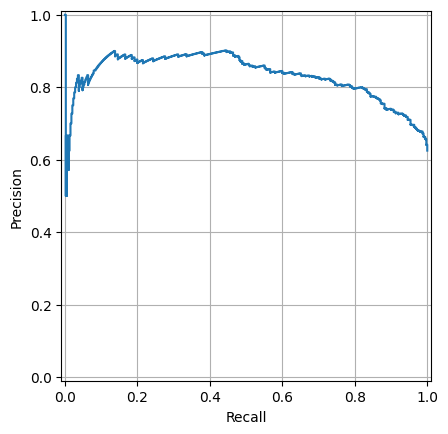

In [43]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.grid(True)
plt.show()

## CLASSICAL MODEL

In [44]:
# epochs = 10
epochs = 30
device = "cpu"
classical_model = ClassicalModel()

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 114
Trainable params: 114
Non-trainable params: 0

In [45]:
run_kfold_training(classical_model, train_dataset, optimizer, criterion, classical=True, k=3, num_epochs=epochs, seed=42)


 Fold 1/3


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 310.63it/s, loss=0.6160, acc=0.8561]


Train loss: 0.7045 | Train acc: 0.4841 | Train rec: 0.4841 | Train prec: 0.7651 | Train f1: 0.4871
Val loss: 0.6160 | Val acc: 0.8561 | Val rec: 0.8561 | Val prec: 0.8606 | Val f1: 0.8561


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 282.85it/s, loss=0.4598, acc=0.8344]


Train loss: 0.5402 | Train acc: 0.8177 | Train rec: 0.8177 | Train prec: 0.8408 | Train f1: 0.7815
Val loss: 0.4598 | Val acc: 0.8344 | Val rec: 0.8344 | Val prec: 0.8556 | Val f1: 0.8344


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 323.69it/s, loss=0.3424, acc=0.8822]


Train loss: 0.4010 | Train acc: 0.8502 | Train rec: 0.8502 | Train prec: 0.8590 | Train f1: 0.8318
Val loss: 0.3424 | Val acc: 0.8822 | Val rec: 0.8822 | Val prec: 0.8832 | Val f1: 0.8822


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 304.58it/s, loss=0.2831, acc=0.8962]


Train loss: 0.3111 | Train acc: 0.8815 | Train rec: 0.8815 | Train prec: 0.8802 | Train f1: 0.8751
Val loss: 0.2831 | Val acc: 0.8962 | Val rec: 0.8962 | Val prec: 0.8940 | Val f1: 0.8962


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 293.84it/s, loss=0.2605, acc=0.8968]


Train loss: 0.2717 | Train acc: 0.8891 | Train rec: 0.8891 | Train prec: 0.8866 | Train f1: 0.8869
Val loss: 0.2605 | Val acc: 0.8968 | Val rec: 0.8968 | Val prec: 0.8946 | Val f1: 0.8968


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 306.41it/s, loss=0.2510, acc=0.8981]


Train loss: 0.2558 | Train acc: 0.8910 | Train rec: 0.8910 | Train prec: 0.8886 | Train f1: 0.8889
Val loss: 0.2510 | Val acc: 0.8981 | Val rec: 0.8981 | Val prec: 0.8965 | Val f1: 0.8981


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 290.62it/s, loss=0.2455, acc=0.9000]


Train loss: 0.2481 | Train acc: 0.8920 | Train rec: 0.8920 | Train prec: 0.8900 | Train f1: 0.8906
Val loss: 0.2455 | Val acc: 0.9000 | Val rec: 0.9000 | Val prec: 0.8987 | Val f1: 0.9000


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 293.84it/s, loss=0.2419, acc=0.9019]


Train loss: 0.2434 | Train acc: 0.8913 | Train rec: 0.8913 | Train prec: 0.8896 | Train f1: 0.8902
Val loss: 0.2419 | Val acc: 0.9019 | Val rec: 0.9019 | Val prec: 0.9005 | Val f1: 0.9019


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 301.03it/s, loss=0.2405, acc=0.8994]


Train loss: 0.2398 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8915 | Train f1: 0.8919
Val loss: 0.2405 | Val acc: 0.8994 | Val rec: 0.8994 | Val prec: 0.8984 | Val f1: 0.8994


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 299.22it/s, loss=0.2375, acc=0.9032]


Train loss: 0.2374 | Train acc: 0.8936 | Train rec: 0.8936 | Train prec: 0.8920 | Train f1: 0.8925
Val loss: 0.2375 | Val acc: 0.9032 | Val rec: 0.9032 | Val prec: 0.9020 | Val f1: 0.9032


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 288.14it/s, loss=0.2354, acc=0.9025]


Train loss: 0.2346 | Train acc: 0.8958 | Train rec: 0.8958 | Train prec: 0.8940 | Train f1: 0.8945
Val loss: 0.2354 | Val acc: 0.9025 | Val rec: 0.9025 | Val prec: 0.9015 | Val f1: 0.9025


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 312.66it/s, loss=0.2332, acc=0.9038]


Train loss: 0.2325 | Train acc: 0.8964 | Train rec: 0.8964 | Train prec: 0.8949 | Train f1: 0.8954
Val loss: 0.2332 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9026 | Val f1: 0.9038


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 276.79it/s, loss=0.2318, acc=0.9045]


Train loss: 0.2305 | Train acc: 0.8964 | Train rec: 0.8964 | Train prec: 0.8948 | Train f1: 0.8954
Val loss: 0.2318 | Val acc: 0.9045 | Val rec: 0.9045 | Val prec: 0.9033 | Val f1: 0.9045


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 304.35it/s, loss=0.2301, acc=0.9051]


Train loss: 0.2284 | Train acc: 0.8990 | Train rec: 0.8990 | Train prec: 0.8977 | Train f1: 0.8982
Val loss: 0.2301 | Val acc: 0.9051 | Val rec: 0.9051 | Val prec: 0.9038 | Val f1: 0.9051


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 296.33it/s, loss=0.2290, acc=0.9057]


Train loss: 0.2270 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8972 | Train f1: 0.8977
Val loss: 0.2290 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9046 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 296.05it/s, loss=0.2279, acc=0.9051]


Train loss: 0.2252 | Train acc: 0.9003 | Train rec: 0.9003 | Train prec: 0.8990 | Train f1: 0.8994
Val loss: 0.2279 | Val acc: 0.9051 | Val rec: 0.9051 | Val prec: 0.9040 | Val f1: 0.9051


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 300.63it/s, loss=0.2272, acc=0.9070]


Train loss: 0.2241 | Train acc: 0.8999 | Train rec: 0.8999 | Train prec: 0.8984 | Train f1: 0.8989
Val loss: 0.2272 | Val acc: 0.9070 | Val rec: 0.9070 | Val prec: 0.9062 | Val f1: 0.9070


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 298.29it/s, loss=0.2265, acc=0.9089]


Train loss: 0.2228 | Train acc: 0.8987 | Train rec: 0.8987 | Train prec: 0.8977 | Train f1: 0.8981
Val loss: 0.2265 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9082 | Val f1: 0.9089


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 276.44it/s, loss=0.2252, acc=0.9070]


Train loss: 0.2218 | Train acc: 0.9031 | Train rec: 0.9031 | Train prec: 0.9026 | Train f1: 0.9028
Val loss: 0.2252 | Val acc: 0.9070 | Val rec: 0.9070 | Val prec: 0.9057 | Val f1: 0.9070


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 299.50it/s, loss=0.2249, acc=0.9070]


Train loss: 0.2208 | Train acc: 0.9044 | Train rec: 0.9044 | Train prec: 0.9035 | Train f1: 0.9039
Val loss: 0.2249 | Val acc: 0.9070 | Val rec: 0.9070 | Val prec: 0.9063 | Val f1: 0.9070


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 297.06it/s, loss=0.2239, acc=0.9096]


Train loss: 0.2199 | Train acc: 0.9025 | Train rec: 0.9025 | Train prec: 0.9015 | Train f1: 0.9019
Val loss: 0.2239 | Val acc: 0.9096 | Val rec: 0.9096 | Val prec: 0.9086 | Val f1: 0.9096


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 281.95it/s, loss=0.2239, acc=0.9076]


Train loss: 0.2195 | Train acc: 0.9015 | Train rec: 0.9015 | Train prec: 0.9003 | Train f1: 0.9008
Val loss: 0.2239 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9070 | Val f1: 0.9076


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 285.43it/s, loss=0.2232, acc=0.9089]


Train loss: 0.2186 | Train acc: 0.9022 | Train rec: 0.9022 | Train prec: 0.9012 | Train f1: 0.9016
Val loss: 0.2232 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9083 | Val f1: 0.9089


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 305.86it/s, loss=0.2232, acc=0.9096]


Train loss: 0.2182 | Train acc: 0.9015 | Train rec: 0.9015 | Train prec: 0.9003 | Train f1: 0.9008
Val loss: 0.2232 | Val acc: 0.9096 | Val rec: 0.9096 | Val prec: 0.9090 | Val f1: 0.9096


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 291.96it/s, loss=0.2226, acc=0.9076]


Train loss: 0.2178 | Train acc: 0.9031 | Train rec: 0.9031 | Train prec: 0.9025 | Train f1: 0.9028
Val loss: 0.2226 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9067 | Val f1: 0.9076


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 302.59it/s, loss=0.2224, acc=0.9083]


Train loss: 0.2171 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9045 | Train f1: 0.9048
Val loss: 0.2224 | Val acc: 0.9083 | Val rec: 0.9083 | Val prec: 0.9074 | Val f1: 0.9083


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 301.25it/s, loss=0.2224, acc=0.9083]


Train loss: 0.2172 | Train acc: 0.9044 | Train rec: 0.9044 | Train prec: 0.9034 | Train f1: 0.9038
Val loss: 0.2224 | Val acc: 0.9083 | Val rec: 0.9083 | Val prec: 0.9074 | Val f1: 0.9083


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 298.54it/s, loss=0.2222, acc=0.9083]


Train loss: 0.2167 | Train acc: 0.9050 | Train rec: 0.9050 | Train prec: 0.9044 | Train f1: 0.9047
Val loss: 0.2222 | Val acc: 0.9083 | Val rec: 0.9083 | Val prec: 0.9072 | Val f1: 0.9083


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 297.08it/s, loss=0.2236, acc=0.9070]


Train loss: 0.2160 | Train acc: 0.9031 | Train rec: 0.9031 | Train prec: 0.9020 | Train f1: 0.9024
Val loss: 0.2236 | Val acc: 0.9070 | Val rec: 0.9070 | Val prec: 0.9072 | Val f1: 0.9070


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 295.43it/s, loss=0.2228, acc=0.9070]


Train loss: 0.2164 | Train acc: 0.9044 | Train rec: 0.9044 | Train prec: 0.9037 | Train f1: 0.9040
Val loss: 0.2228 | Val acc: 0.9070 | Val rec: 0.9070 | Val prec: 0.9072 | Val f1: 0.9070

 Fold 2/3


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 286.81it/s, loss=0.2233, acc=0.9057]


Train loss: 0.2160 | Train acc: 0.9051 | Train rec: 0.9051 | Train prec: 0.9051 | Train f1: 0.9051
Val loss: 0.2233 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9050 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 288.11it/s, loss=0.2236, acc=0.9038]


Train loss: 0.2145 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9050 | Train f1: 0.9052
Val loss: 0.2236 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9025 | Val f1: 0.9038


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 304.87it/s, loss=0.2235, acc=0.9050]


Train loss: 0.2143 | Train acc: 0.9067 | Train rec: 0.9067 | Train prec: 0.9055 | Train f1: 0.9059
Val loss: 0.2235 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9044 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 293.35it/s, loss=0.2232, acc=0.9050]


Train loss: 0.2146 | Train acc: 0.9047 | Train rec: 0.9047 | Train prec: 0.9049 | Train f1: 0.9048
Val loss: 0.2232 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9039 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 303.94it/s, loss=0.2238, acc=0.9050]


Train loss: 0.2139 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9044 | Train f1: 0.9048
Val loss: 0.2238 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9050 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 304.58it/s, loss=0.2231, acc=0.9063]


Train loss: 0.2143 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9073 | Train f1: 0.9073
Val loss: 0.2231 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9055 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 292.45it/s, loss=0.2230, acc=0.9050]


Train loss: 0.2134 | Train acc: 0.9070 | Train rec: 0.9070 | Train prec: 0.9064 | Train f1: 0.9066
Val loss: 0.2230 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9041 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 296.36it/s, loss=0.2231, acc=0.9050]


Train loss: 0.2134 | Train acc: 0.9063 | Train rec: 0.9063 | Train prec: 0.9055 | Train f1: 0.9059
Val loss: 0.2231 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9041 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 318.11it/s, loss=0.2231, acc=0.9044]


Train loss: 0.2134 | Train acc: 0.9063 | Train rec: 0.9063 | Train prec: 0.9056 | Train f1: 0.9059
Val loss: 0.2231 | Val acc: 0.9044 | Val rec: 0.9044 | Val prec: 0.9033 | Val f1: 0.9044


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 288.89it/s, loss=0.2228, acc=0.9057]


Train loss: 0.2135 | Train acc: 0.9076 | Train rec: 0.9076 | Train prec: 0.9071 | Train f1: 0.9073
Val loss: 0.2228 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9048 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 287.61it/s, loss=0.2228, acc=0.9089]


Train loss: 0.2127 | Train acc: 0.9060 | Train rec: 0.9060 | Train prec: 0.9050 | Train f1: 0.9054
Val loss: 0.2228 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9084 | Val f1: 0.9089


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 292.79it/s, loss=0.2227, acc=0.9050]


Train loss: 0.2130 | Train acc: 0.9063 | Train rec: 0.9063 | Train prec: 0.9057 | Train f1: 0.9060
Val loss: 0.2227 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9041 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 291.44it/s, loss=0.2231, acc=0.9057]


Train loss: 0.2128 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9067 | Train f1: 0.9069
Val loss: 0.2231 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9043 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 322.61it/s, loss=0.2226, acc=0.9057]


Train loss: 0.2127 | Train acc: 0.9063 | Train rec: 0.9063 | Train prec: 0.9052 | Train f1: 0.9056
Val loss: 0.2226 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9048 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 308.99it/s, loss=0.2224, acc=0.9063]


Train loss: 0.2123 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9067 | Train f1: 0.9069
Val loss: 0.2224 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9053 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 276.41it/s, loss=0.2223, acc=0.9050]


Train loss: 0.2124 | Train acc: 0.9057 | Train rec: 0.9057 | Train prec: 0.9048 | Train f1: 0.9052
Val loss: 0.2223 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9039 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 293.00it/s, loss=0.2222, acc=0.9050]


Train loss: 0.2120 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9065 | Train f1: 0.9068
Val loss: 0.2222 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9039 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 303.78it/s, loss=0.2220, acc=0.9076]


Train loss: 0.2119 | Train acc: 0.9076 | Train rec: 0.9076 | Train prec: 0.9065 | Train f1: 0.9069
Val loss: 0.2220 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9067 | Val f1: 0.9076


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 302.71it/s, loss=0.2220, acc=0.9050]


Train loss: 0.2123 | Train acc: 0.9067 | Train rec: 0.9067 | Train prec: 0.9060 | Train f1: 0.9063
Val loss: 0.2220 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9039 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 283.60it/s, loss=0.2224, acc=0.9038]


Train loss: 0.2117 | Train acc: 0.9060 | Train rec: 0.9060 | Train prec: 0.9054 | Train f1: 0.9057
Val loss: 0.2224 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9024 | Val f1: 0.9038


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 301.03it/s, loss=0.2220, acc=0.9038]


Train loss: 0.2119 | Train acc: 0.9079 | Train rec: 0.9079 | Train prec: 0.9070 | Train f1: 0.9073
Val loss: 0.2220 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9025 | Val f1: 0.9038


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 288.09it/s, loss=0.2216, acc=0.9057]


Train loss: 0.2112 | Train acc: 0.9054 | Train rec: 0.9054 | Train prec: 0.9047 | Train f1: 0.9050
Val loss: 0.2216 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9046 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 293.19it/s, loss=0.2218, acc=0.9038]


Train loss: 0.2113 | Train acc: 0.9086 | Train rec: 0.9086 | Train prec: 0.9077 | Train f1: 0.9081
Val loss: 0.2218 | Val acc: 0.9038 | Val rec: 0.9038 | Val prec: 0.9025 | Val f1: 0.9038


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 291.39it/s, loss=0.2217, acc=0.9044]


Train loss: 0.2112 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9064 | Train f1: 0.9068
Val loss: 0.2217 | Val acc: 0.9044 | Val rec: 0.9044 | Val prec: 0.9032 | Val f1: 0.9044


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 301.52it/s, loss=0.2215, acc=0.9050]


Train loss: 0.2113 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9065 | Train f1: 0.9069
Val loss: 0.2215 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9039 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 276.26it/s, loss=0.2214, acc=0.9057]


Train loss: 0.2108 | Train acc: 0.9083 | Train rec: 0.9083 | Train prec: 0.9076 | Train f1: 0.9079
Val loss: 0.2214 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9045 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 288.51it/s, loss=0.2220, acc=0.9050]


Train loss: 0.2105 | Train acc: 0.9092 | Train rec: 0.9092 | Train prec: 0.9087 | Train f1: 0.9089
Val loss: 0.2220 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9035 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 320.28it/s, loss=0.2215, acc=0.9063]


Train loss: 0.2104 | Train acc: 0.9083 | Train rec: 0.9083 | Train prec: 0.9074 | Train f1: 0.9077
Val loss: 0.2215 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9053 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 309.26it/s, loss=0.2213, acc=0.9063]


Train loss: 0.2102 | Train acc: 0.9079 | Train rec: 0.9079 | Train prec: 0.9072 | Train f1: 0.9075
Val loss: 0.2213 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9051 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 303.28it/s, loss=0.2212, acc=0.9057]


Train loss: 0.2103 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9065 | Train f1: 0.9069
Val loss: 0.2212 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9045 | Val f1: 0.9057

 Fold 3/3


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 299.20it/s, loss=0.2049, acc=0.9069]


Train loss: 0.2183 | Train acc: 0.9070 | Train rec: 0.9070 | Train prec: 0.9058 | Train f1: 0.9062
Val loss: 0.2049 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9059 | Val f1: 0.9069


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 308.04it/s, loss=0.2053, acc=0.9069]


Train loss: 0.2177 | Train acc: 0.9076 | Train rec: 0.9076 | Train prec: 0.9063 | Train f1: 0.9067
Val loss: 0.2053 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9060 | Val f1: 0.9069


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 287.18it/s, loss=0.2051, acc=0.9089]


Train loss: 0.2178 | Train acc: 0.9073 | Train rec: 0.9073 | Train prec: 0.9063 | Train f1: 0.9067
Val loss: 0.2051 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9083 | Val f1: 0.9089


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 294.52it/s, loss=0.2058, acc=0.9069]


Train loss: 0.2175 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9081 | Train f1: 0.9084
Val loss: 0.2058 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9059 | Val f1: 0.9069


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 318.71it/s, loss=0.2056, acc=0.9069]


Train loss: 0.2173 | Train acc: 0.9076 | Train rec: 0.9076 | Train prec: 0.9063 | Train f1: 0.9068
Val loss: 0.2056 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9060 | Val f1: 0.9069


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 314.51it/s, loss=0.2053, acc=0.9076]


Train loss: 0.2171 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9077 | Train f1: 0.9081
Val loss: 0.2053 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9069 | Val f1: 0.9076


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 290.04it/s, loss=0.2057, acc=0.9069]


Train loss: 0.2182 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9081 | Train f1: 0.9084
Val loss: 0.2057 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9063 | Val f1: 0.9069


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 320.14it/s, loss=0.2055, acc=0.9076]


Train loss: 0.2173 | Train acc: 0.9092 | Train rec: 0.9092 | Train prec: 0.9084 | Train f1: 0.9087
Val loss: 0.2055 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9071 | Val f1: 0.9076


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 308.18it/s, loss=0.2055, acc=0.9057]


Train loss: 0.2168 | Train acc: 0.9086 | Train rec: 0.9086 | Train prec: 0.9076 | Train f1: 0.9080
Val loss: 0.2055 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9048 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 290.76it/s, loss=0.2057, acc=0.9063]


Train loss: 0.2164 | Train acc: 0.9095 | Train rec: 0.9095 | Train prec: 0.9086 | Train f1: 0.9090
Val loss: 0.2057 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9055 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 289.68it/s, loss=0.2056, acc=0.9063]


Train loss: 0.2165 | Train acc: 0.9086 | Train rec: 0.9086 | Train prec: 0.9075 | Train f1: 0.9079
Val loss: 0.2056 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9056 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 301.56it/s, loss=0.2059, acc=0.9069]


Train loss: 0.2165 | Train acc: 0.9098 | Train rec: 0.9098 | Train prec: 0.9088 | Train f1: 0.9091
Val loss: 0.2059 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9060 | Val f1: 0.9069


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 301.80it/s, loss=0.2061, acc=0.9069]


Train loss: 0.2164 | Train acc: 0.9098 | Train rec: 0.9098 | Train prec: 0.9090 | Train f1: 0.9093
Val loss: 0.2061 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9064 | Val f1: 0.9069


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 301.18it/s, loss=0.2061, acc=0.9063]


Train loss: 0.2158 | Train acc: 0.9108 | Train rec: 0.9108 | Train prec: 0.9098 | Train f1: 0.9102
Val loss: 0.2061 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9055 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 299.14it/s, loss=0.2058, acc=0.9063]


Train loss: 0.2158 | Train acc: 0.9092 | Train rec: 0.9092 | Train prec: 0.9081 | Train f1: 0.9085
Val loss: 0.2058 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9064 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 306.01it/s, loss=0.2055, acc=0.9063]


Train loss: 0.2159 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9078 | Train f1: 0.9082
Val loss: 0.2055 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9058 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 314.75it/s, loss=0.2066, acc=0.9057]


Train loss: 0.2153 | Train acc: 0.9118 | Train rec: 0.9118 | Train prec: 0.9110 | Train f1: 0.9113
Val loss: 0.2066 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9046 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 309.66it/s, loss=0.2060, acc=0.9063]


Train loss: 0.2158 | Train acc: 0.9102 | Train rec: 0.9102 | Train prec: 0.9090 | Train f1: 0.9094
Val loss: 0.2060 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9055 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 306.62it/s, loss=0.2056, acc=0.9063]


Train loss: 0.2156 | Train acc: 0.9098 | Train rec: 0.9098 | Train prec: 0.9088 | Train f1: 0.9091
Val loss: 0.2056 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9057 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 295.87it/s, loss=0.2059, acc=0.9057]


Train loss: 0.2155 | Train acc: 0.9098 | Train rec: 0.9098 | Train prec: 0.9088 | Train f1: 0.9091
Val loss: 0.2059 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9054 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 295.86it/s, loss=0.2058, acc=0.9063]


Train loss: 0.2152 | Train acc: 0.9105 | Train rec: 0.9105 | Train prec: 0.9096 | Train f1: 0.9099
Val loss: 0.2058 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9057 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 310.86it/s, loss=0.2057, acc=0.9076]


Train loss: 0.2149 | Train acc: 0.9102 | Train rec: 0.9102 | Train prec: 0.9090 | Train f1: 0.9094
Val loss: 0.2057 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9070 | Val f1: 0.9076


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 308.95it/s, loss=0.2058, acc=0.9057]


Train loss: 0.2151 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9078 | Train f1: 0.9082
Val loss: 0.2058 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9054 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 294.56it/s, loss=0.2063, acc=0.9050]


Train loss: 0.2156 | Train acc: 0.9092 | Train rec: 0.9092 | Train prec: 0.9080 | Train f1: 0.9084
Val loss: 0.2063 | Val acc: 0.9050 | Val rec: 0.9050 | Val prec: 0.9042 | Val f1: 0.9050


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 298.32it/s, loss=0.2062, acc=0.9089]


Train loss: 0.2148 | Train acc: 0.9098 | Train rec: 0.9098 | Train prec: 0.9084 | Train f1: 0.9087
Val loss: 0.2062 | Val acc: 0.9089 | Val rec: 0.9089 | Val prec: 0.9089 | Val f1: 0.9089


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 289.84it/s, loss=0.2059, acc=0.9076]


Train loss: 0.2148 | Train acc: 0.9108 | Train rec: 0.9108 | Train prec: 0.9101 | Train f1: 0.9104
Val loss: 0.2059 | Val acc: 0.9076 | Val rec: 0.9076 | Val prec: 0.9071 | Val f1: 0.9076


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 307.57it/s, loss=0.2061, acc=0.9069]


Train loss: 0.2150 | Train acc: 0.9105 | Train rec: 0.9105 | Train prec: 0.9094 | Train f1: 0.9097
Val loss: 0.2061 | Val acc: 0.9069 | Val rec: 0.9069 | Val prec: 0.9069 | Val f1: 0.9069


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 305.25it/s, loss=0.2058, acc=0.9063]


Train loss: 0.2145 | Train acc: 0.9105 | Train rec: 0.9105 | Train prec: 0.9095 | Train f1: 0.9099
Val loss: 0.2058 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9062 | Val f1: 0.9063


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 275.71it/s, loss=0.2061, acc=0.9057]


Train loss: 0.2149 | Train acc: 0.9114 | Train rec: 0.9114 | Train prec: 0.9109 | Train f1: 0.9111
Val loss: 0.2061 | Val acc: 0.9057 | Val rec: 0.9057 | Val prec: 0.9049 | Val f1: 0.9057


Training: 100%|███████████████████████████████████████████████| 50/50 [00:00<00:00, 295.91it/s, loss=0.2059, acc=0.9063]


Train loss: 0.2143 | Train acc: 0.9089 | Train rec: 0.9089 | Train prec: 0.9077 | Train f1: 0.9081
Val loss: 0.2059 | Val acc: 0.9063 | Val rec: 0.9063 | Val prec: 0.9061 | Val f1: 0.9063


In [46]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

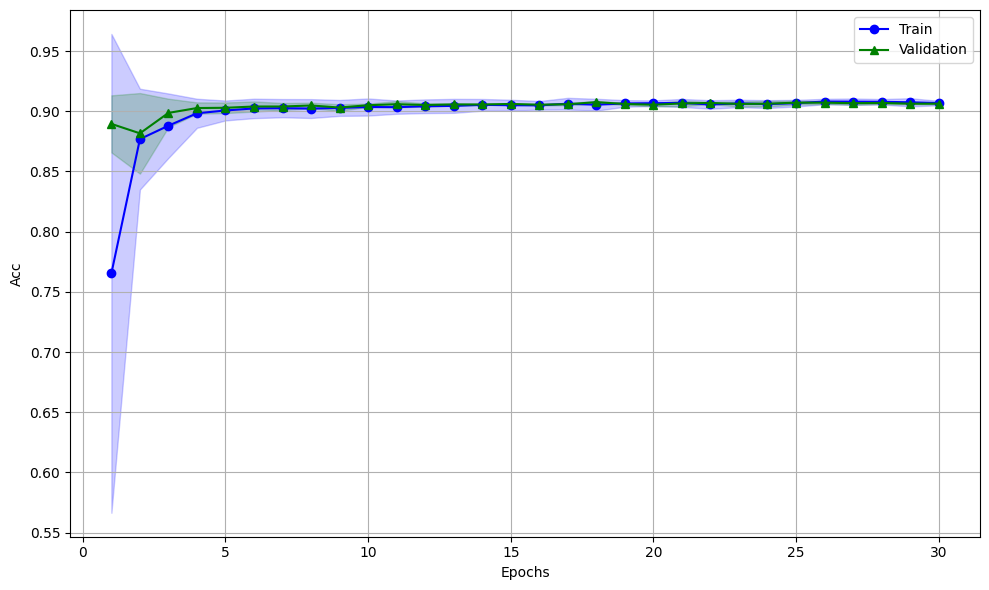

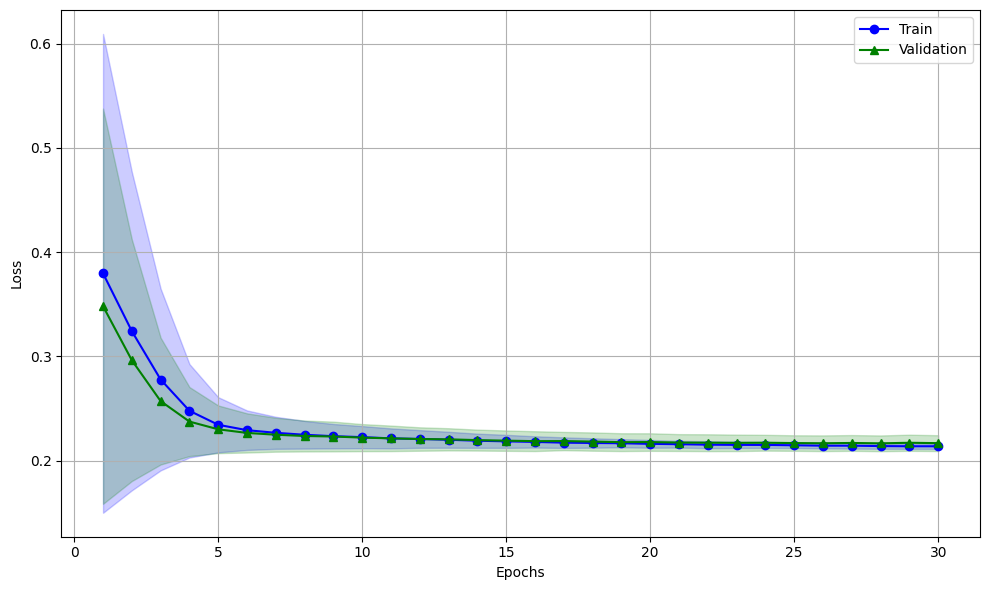

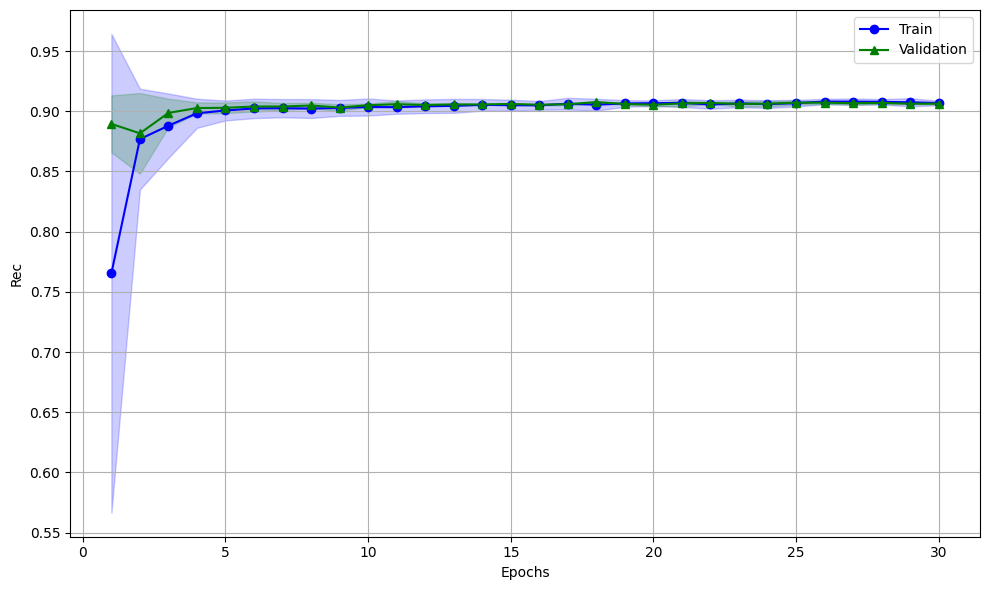

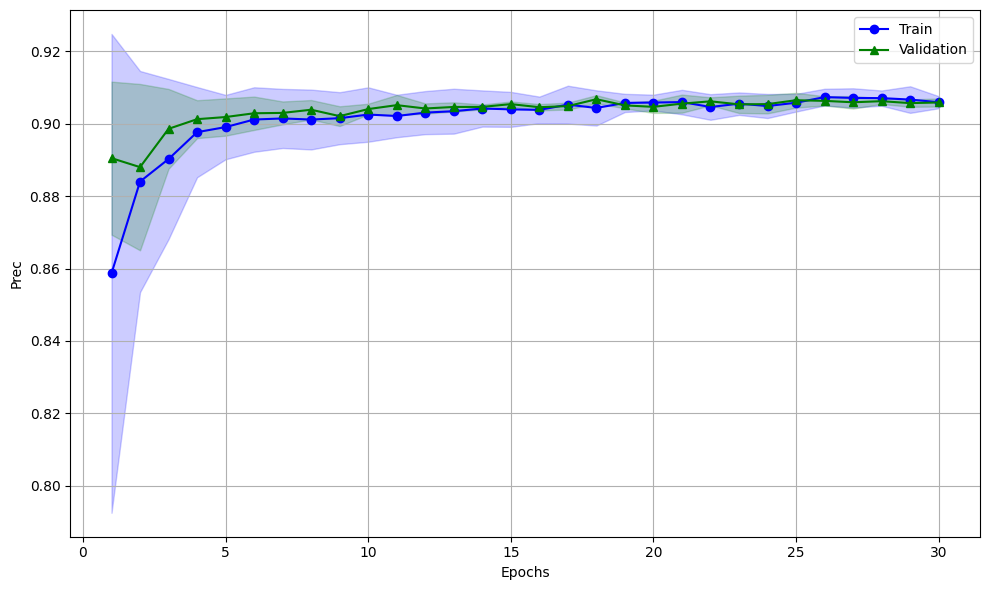

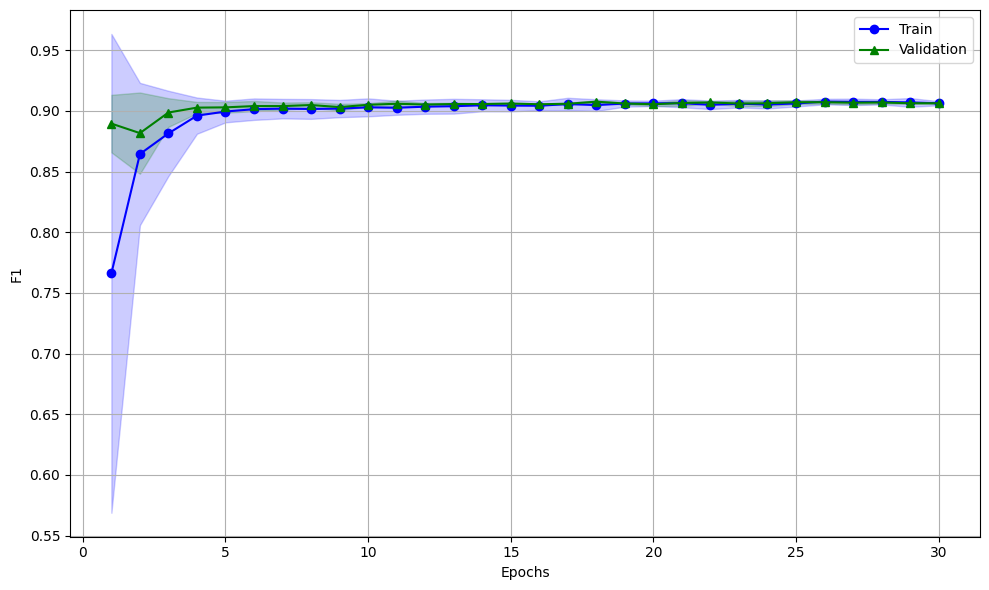

In [47]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range)
    metrics_summary[metric] = summary

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [48]:
# c_train_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }
# c_val_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# best_val_f1 = 0

# for epoch in range(epochs):
#     print(f"epoch {epoch+1}/{epochs}")
#     # train_loss, train_acc = train(classical_model, train_loader, optimizer, criterion, device)
#     train_loss, train_acc, train_prec, train_rec, train_f1, c_train_report = train_v2(classical_model, train_loader, optimizer, criterion, device)
#     # val_loss, val_acc = evaluate(classical_model, val_loader, criterion, device)
#     val_loss, val_acc, val_prec, val_rec, val_f1, c_val_report, val_preds, val_probs, val_labels = evaluate_v2(classical_model, val_loader, criterion, device)

#     c_train_metrics["acc"].append(train_acc)
#     c_train_metrics["loss"].append(train_loss)
#     c_train_metrics["rec"].append(train_rec)
#     c_train_metrics["prec"].append(train_prec)
#     c_train_metrics["f1"].append(train_f1)
        
#     c_val_metrics["acc"].append(val_acc)
#     c_val_metrics["loss"].append(val_loss)
#     c_val_metrics["rec"].append(val_rec)
#     c_val_metrics["prec"].append(val_prec)
#     c_val_metrics["f1"].append(val_f1)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(classical_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth")


#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


#     tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


# with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_train_metrics.json", "w") as f:
#     json.dump(c_train_metrics, f, indent=4)

# with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_val_metrics.json", "w") as f:
#     json.dump(c_val_metrics, f, indent=4)
    
#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

In [49]:
# epochs = range(1, len(c_train_metrics["acc"]) + 1)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, c_train_metrics["loss"], label="Train Loss", marker="o")
# plt.plot(epochs, c_val_metrics["loss"], label="Validation Loss", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# # plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
# plt.plot(epochs, c_train_metrics["acc"], label="Train Accuracies", marker="o")
# plt.plot(epochs, c_val_metrics["acc"], label="Validation Accuracies", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)    

# plt.tight_layout()
# plt.show()

In [50]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 1 with val_f1 = 0.9070


In [51]:
test_classical_model = ClassicalModel()
# test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth"))
test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_1_best.pth"))
test_classical_model.to(device)

c_test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_classical_model, test_loader, criterion, device)

c_test_metrics["acc"].append(test_acc)
c_test_metrics["loss"].append(test_loss)
c_test_metrics["rec"].append(test_rec)
c_test_metrics["prec"].append(test_prec)
c_test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_test_metrics.json", "w") as f:
    json.dump(c_test_metrics, f, indent=4)

Training: 100%|███████████████████████████████████████████████| 20/20 [00:00<00:00, 291.54it/s, loss=0.6433, acc=0.7260]

Test loss: 0.6433 | Test acc: 0.7260 | Test rec: 0.7260 | Test prec: 0.7223 | Test f1: 0.7260


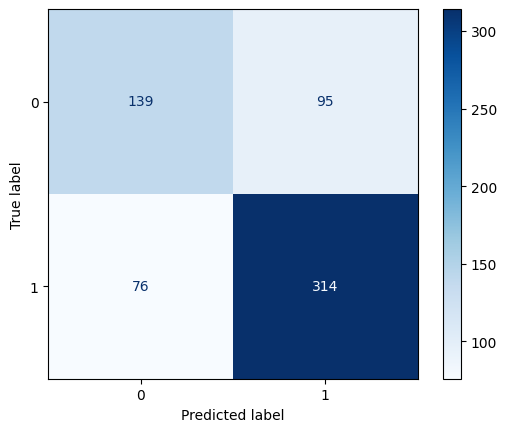

In [52]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

AUROC: 0.779333771641464


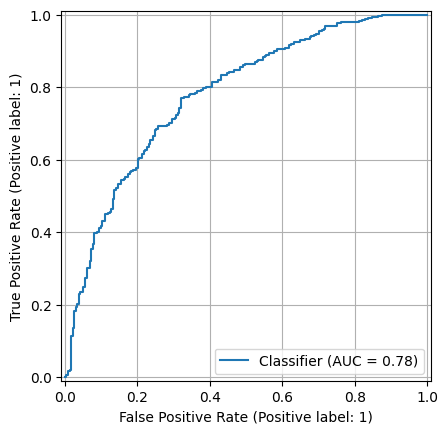

In [53]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
print("AUROC:", auroc)

RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
plt.grid()
plt.show()

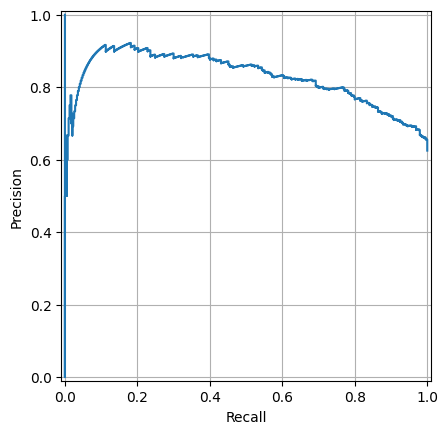

In [54]:

y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.grid(True)
plt.show()